In [47]:
# Licenta
# This is a work in progress that tries to segment bladder cancer
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [48]:
import os
inputFolder = '../input/'
for root, directories, filenames in os.walk(inputFolder):
    for filename in filenames: print(os.path.join(root,filename))

../input/date5perpacient/x_second_batch.npz
../input/date5perpacient/y_valid_first_batch.npz
../input/date5perpacient/x_valid_first_batch.npz
../input/date5perpacient/y_valid_second_batch.npz
../input/date5perpacient/x_valid_second_batch.npz
../input/date5perpacient/x_first_batch.npz
../input/date5perpacient/y_test.npz
../input/date5perpacient/y_second_batch.npz
../input/date5perpacient/x_test.npz
../input/date5perpacient/y_first_batch.npz
../input/date5perpacient/__results___files/__results___41_1.png
../input/date5perpacient/__results___files/__results___11_0.png
../input/date5perpacient/__results___files/__results___61_0.png
../input/date5perpacient/__results___files/__results___10_0.png
../input/date5perpacient/__results___files/__results___31_0.png
../input/date5perpacient/__results___files/__results___63_0.png
../input/date5perpacient/__results___files/__results___12_0.png
../input/date5perpacient/__results___files/__results___30_0.png
../input/date5perpacient/__results___files/_

# Importing the libraries

In [49]:
!pip install pynrrd

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [50]:
%matplotlib inline

# Importing libraries needed for data processing

import os
import numpy as np
import nrrd
import tensorflow as tf
from numpy import load
# Adding a path

from pathlib import Path


# Necessary libraries for image alteration and animations

from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from scipy import ndimage
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Keras
import os
import skimage.io as io
import skimage.transform as trans


In [51]:

from tensorflow.keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping , ReduceLROnPlateau
from keras import backend as keras
from keras import utils
from keras.utils import np_utils
from functools import partial
from keras import backend as K


# Importing needed libraries for constructing 3DUnet
from keras.layers import Input, LeakyReLU, Add, UpSampling3D, Activation, SpatialDropout3D, Conv3D,Conv3DTranspose,PReLU,Softmax,ReLU,Concatenate 
from keras.engine import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.losses import categorical_crossentropy,mse

# K.set_image_data_format("channels_first")
K.set_image_data_format("channels_last")

# Time
from tqdm.notebook import tqdm
import time
import datetime

# Visualization
import tensorboard

# Post-processing
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

# Loading the data

In [52]:
# Data from the second batch of patients
def get_test_data(package):
    x_test = load('../input/'+ package +'/x_test.npz')
    y_test = load('../input/'+ package +'/y_test.npz')
    
    x_test = x_test['arr_0']
    y_test = y_test['arr_0']
    
    return x_test, y_test

## Creating the used functions for the models

In [53]:
#INCERCATE DAR NIMIC BUN

def dice_coefficient(y_true, y_pred, smooth=1.):
    """
    Calcularea coeficientul DICE
    :param y_true:(3D Numpy Array) imaginea originala
    :param y_true:(3D Numpy Array) imaginea prezisa de model
    :returns:
    coeficientul DICE (float)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def auc(y_true, y_pred):
    smooth = 1
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + smooth) / (tp + fn + smooth) #recall
    tnr = (tn + smooth) / (tn + fp + smooth)
    prec = (tp + smooth) / (tp + fp + smooth) #precision
    return [tpr, tnr, prec]

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tanimoto_coefficient(y_true, y_pred, smooth=1.):
    """
    Calcularea coeficientul DICE
    :param y_true:(3D Numpy Array) imaginea originala
    :param y_true:(3D Numpy Array) imaginea prezisa de model
    :returns:
    coeficientul DICE (float)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

In [54]:
def calculate_dice(y_true,y_pred):
    dice=dice_coefficient(y_true,y_pred)
    result=round(tf.keras.backend.get_value(dice),3)
    return result

In [55]:
def choose_slice(patient):
    max_t_px = 0
    nr_slice = 0
    for x in range(patient.shape[2]):
        px = np.count_nonzero(patient[:,:,x,1] == 1)
        if px >= max_t_px:
            nr_slice = x
            max_t_px = px
    return nr_slice

In [56]:
def choose_slice_best(patient,true):
    volume = np.copy(patient)
    max_dice = 0
    nr_slice = 0
    for z in range(patient.shape[2]):
        pat = np.copy(patient)
        dice, _ = automate_thrs(pat,true,z,1)
        px = np.count_nonzero(true[:,:,z,1] == 1)

        if dice>max_dice and px>0:
            max_dice = dice
            nr_slice = z
    return nr_slice

In [57]:
def automate_thrs(volume,true,x,cls):
    
    thrs = [i/100 for i in range(100)]
    max_dice = 0
    thr_max = 0

    for t in thrs:
        patient = np.copy(volume)
        patient[:,:,x,cls] = np.where( patient[:,:,x,cls]>=t, 1, patient[:,:,x,cls])
        patient[:,:,x,cls] = np.where( patient[:,:,x,cls]<t, 0, patient[:,:,x,cls])
        dice = calculate_dice(true[:,:,x,cls],patient[:,:,x,cls])
        if dice>max_dice:
            thr_max = t
            max_dice = dice
    
    return max_dice, thr_max

In [58]:
def predicted_categorical_truth(patients, predictions, labels, thr_w=0.1,thr_t=0.1,thr_b=0.9):
    fig, ax = plt.subplots(5,7, figsize=[8, 8])
    
#     x = choose_slice(y_test[nr])
    for i in range(5):
        x = choose_slice_best(predictions[i], labels[i])
        img_label_0 = patients[i][:,:,x]
        img_label_1=labels[i][:,:,x,2]
        img_label_3=labels[i][:,:,x,1]
        img_label_5=labels[i][:,:,x,0]

        img_label_2 = np.copy(predictions[i][:,:,x,2])
        img_label_4 = np.copy(predictions[i][:,:,x,1])
        img_label_6 = np.copy(predictions[i][:,:,x,0])


        dice_b, thr_b = automate_thrs(predictions[i],labels[i],x,0)
        dice_p, thr_w = automate_thrs(predictions[i],labels[i],x,2)
        dice_t, thr_t = automate_thrs(predictions[i],labels[i],x,1)

        img_label_2_p = np.where(img_label_2>=thr_w,1,img_label_2)
        img_label_2_p = np.where(img_label_2_p<thr_w,0,img_label_2_p)
        img_label_4_p = np.where(img_label_4>=thr_t,1,img_label_4)
        img_label_4_p = np.where(img_label_4_p<thr_t,0,img_label_4_p)
        img_label_6_p = np.where(img_label_6>=thr_b,1,img_label_6)
        img_label_6_p = np.where(img_label_6_p<thr_b,0,img_label_6_p)

        img_label_2 = img_label_2_p
        img_label_4 = img_label_4_p
        img_label_6 = img_label_6_p


        rotated_img_lb_0 = ndimage.rotate(img_label_0, 270)
        rotated_img_lb_1 = ndimage.rotate(img_label_1, 270)
        rotated_img_lb_2 = ndimage.rotate(img_label_2, 270)
        rotated_img_lb_3 = ndimage.rotate(img_label_3, 270)
        rotated_img_lb_4 = ndimage.rotate(img_label_4, 270)
        rotated_img_lb_5 = ndimage.rotate(img_label_5, 270)
        rotated_img_lb_6 = ndimage.rotate(img_label_6, 270)


        dice_b = round(tf.keras.backend.get_value(dice_b),3)
        dice_p = round(tf.keras.backend.get_value(dice_p),3)
        dice_t = round(tf.keras.backend.get_value(dice_t),3)

        ax[i][0].imshow(rotated_img_lb_0,cmap='gray')
        ax[i][0].axis('off')
        ax[i][1].set_title("    DSC for wall: "+str(dice_p))
        ax[i][1].imshow(rotated_img_lb_1,cmap='gray')
        ax[i][1].axis('off')
    #     ax[0][1].set_title("Dice value for wall: "+str(dice_p))
        ax[i][2].imshow(rotated_img_lb_2,cmap='gray')
        ax[i][2].axis('off')
        ax[i][3].set_title("       DSC for tumor: "+str(dice_t))
        ax[i][3].imshow(rotated_img_lb_3,cmap='gray')
        ax[i][3].axis('off')
        ax[i][4].imshow(rotated_img_lb_4,cmap='gray')
        ax[i][4].axis('off')
        ax[i][5].set_title("       DSC for bg: "+str(dice_b))
        ax[i][5].imshow(rotated_img_lb_5,cmap='gray')
        ax[i][5].axis('off')
        ax[i][6].imshow(rotated_img_lb_6,cmap='gray')
        ax[i][6].axis('off')
    plt.tight_layout()
    plt.show()


## Loading the models

In [59]:
def load_models():
    dependencies = {
        'dice_coefficient' : dice_coefficient,
        'auc' : auc,
        'confusion' : confusion,
        'tanimoto_coefficient' : tanimoto_coefficient
    }

    model_dc = tf.keras.models.load_model("../input/trained-models/model_sigmoid_nuclei.h5", custom_objects=dependencies)
    model_dilated = tf.keras.models.load_model("../input/trained-models/dilated.h5", custom_objects=dependencies)
    return model_dc, model_dilated

## The Menu

In [60]:
def menu():
    print("1. Summary of the Dilated model")
    print("2. Summary of the DC model")
    print("3. Predict with the Dilated UNet model")
    print("4. Predict with the DC UNet model")
    print("5. Visualize predictions for the dilated model")
    print("6. Visualize predictions for the dual channel model")
    print("Exit")

In [61]:
def run():
    package = "date5perpacient"
    x_test, y_test = get_test_data(package)
    patients = x_test
    labels = y_test
    model_dc, model_dilated = load_models()
    predictions_dilated = []
    predictions_dc = []
    print("Welcome to: Bladder segmentation - An analysis of segmentation models")
    while True:
        menu()
        op = int(input("Your choice: "))
        if op == 1:
            print(model_dilated.summary())
        elif op == 2:
            print(model_dc.summary())
        elif op == 3:
            predictions_dilated = model_dilated.predict(patients)
        elif op == 4:
            predictions_dc = model_dc.predict(patients)
        elif op == 5:
            if len(predictions_dilated) ==0:
                print("You have yet to predict using the dilated model.")
                print("You will be redirected to the main menu.")
                continue
            predicted_categorical_truth(patients, predictions_dilated, labels)
        elif op == 6:
            if len(predictions_dc) ==0:
                print("You have yet to predict using the dc model.")
                print("You will be redirected to the main menu.")
                continue
            predicted_categorical_truth(patients, predictions_dc, labels)
        else:
            return

Welcome to: Bladder segmentation - An analysis of segmentation models
1. Summary of the Dilated model
2. Summary of the DC model
3. Predict with the Dilated UNet model
4. Predict with the DC UNet model
5. Visualize predictions for the dilated model
6. Visualize predictions for the dual channel model
Exit


Your choice:  1


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 32, 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32, 128         conv3d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 128, 128, 32, 16777216    batch_normalization[0][0]        
______________________________________________________________________________________________

Your choice:  2


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 32, 135         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_3 (Conv3D)               (None, 128, 128, 32, 135         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32, 0           conv3d[0][0]                     
______________________________________________________________________________________________

Your choice:  3


1. Summary of the Dilated model
2. Summary of the DC model
3. Predict with the Dilated UNet model
4. Predict with the DC UNet model
5. Visualize predictions for the dilated model
6. Visualize predictions for the dual channel model
Exit


Your choice:  6


You have yet to predict using the dc model.
You will be redirected to the main menu.
1. Summary of the Dilated model
2. Summary of the DC model
3. Predict with the Dilated UNet model
4. Predict with the DC UNet model
5. Visualize predictions for the dilated model
6. Visualize predictions for the dual channel model
Exit


Your choice:  5


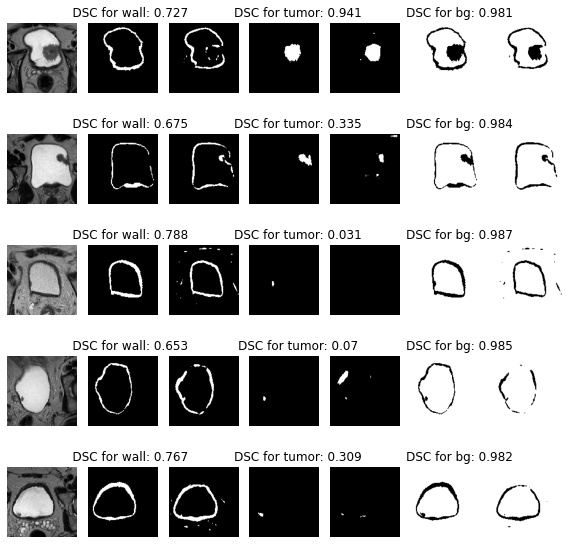

1. Summary of the Dilated model
2. Summary of the DC model
3. Predict with the Dilated UNet model
4. Predict with the DC UNet model
5. Visualize predictions for the dilated model
6. Visualize predictions for the dual channel model
Exit


Your choice:  4


1. Summary of the Dilated model
2. Summary of the DC model
3. Predict with the Dilated UNet model
4. Predict with the DC UNet model
5. Visualize predictions for the dilated model
6. Visualize predictions for the dual channel model
Exit


Your choice:  6


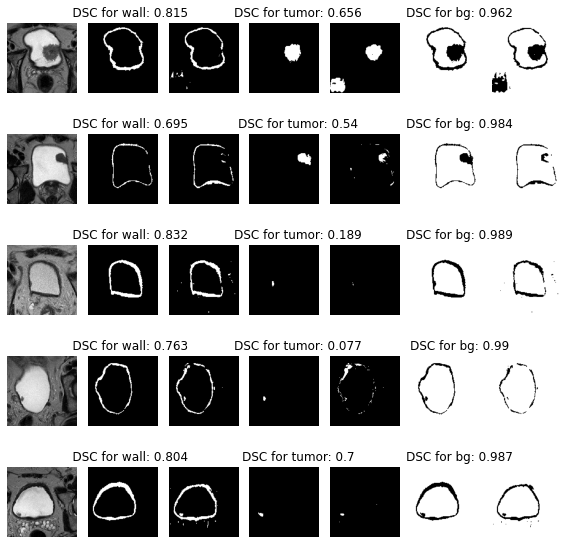

1. Summary of the Dilated model
2. Summary of the DC model
3. Predict with the Dilated UNet model
4. Predict with the DC UNet model
5. Visualize predictions for the dilated model
6. Visualize predictions for the dual channel model
Exit


Your choice:  7


In [62]:
run()